In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [3]:
# Get the Horse or Human training dataset
#!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
#!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

# test_local_zip = './horse-or-human.zip'
# zip_ref = zipfile.ZipFile(test_local_zip, 'r')
# zip_ref.extractall('./tmp/training')

# val_local_zip = './validation-horse-or-human.zip'
# zip_ref = zipfile.ZipFile(val_local_zip, 'r')
# zip_ref.extractall('./tmp/validation')

# zip_ref.close()

In [4]:
# Define the training and validation base directories
train_dir = './tmp/training'
validation_dir = './tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Sample horse image:


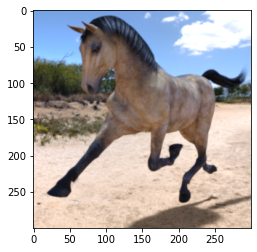


Sample human image:


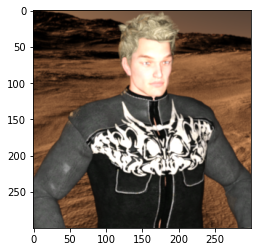

In [5]:
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[1])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

In [6]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


In [8]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale = 1./255.)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator(rescale = 1./255.)
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator


In [9]:
# Test your generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [10]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-07-07 21:53:20--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4007:80f::2010, 2607:f8b0:4007:817::2010, 2607:f8b0:4007:803::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4007:80f::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./tmp/inception_v3_ 100%[===================>]  83.84M  3.14MB/s    in 27s     

2022-07-07 21:53:48 (3.11 MB/s) - ‘./tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [11]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model
  

In [13]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [14]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [16]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [17]:
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output


In [18]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [19]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [20]:
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)     
  x = layers.Dense(1, activation='sigmoid')(x)    

  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  return model


In [21]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [27]:
print([w.shape.num_elements() for w in model.trainable_weights])

[38535168, 1024, 1024, 1]


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [28]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100

Reached 99.9% accuracy so cancelling training!
33/33 - 18s - loss: 1.6695e-05 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9766 - 18s/epoch - 540ms/step


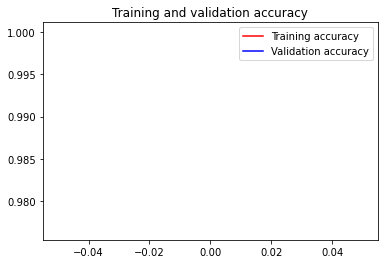

<Figure size 432x288 with 0 Axes>

In [29]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()